Importing Utilized Libraries

In [1]:
import numpy as np
import pandas as pd
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve,auc
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import MinMaxScaler
import math
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


2023-12-17 02:41:37.672826: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 02:41:37.672923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 02:41:37.681656: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 02:41:37.708373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 02:41:39.186177: W tensorflow/compiler/tf2

Defining Classes and Functions

In [2]:

def evaluate_model(model, test_loader, device):
    """
    Function to evaluate the model

    Args:
        model (class): Torch model
        test_loader (str): Torch dataloader
        device (str): Name of device to use for training

    Returns:
        accuracy (float): Accuracy of the model
        precision (float): Precision of the model
        recall (float): Recall of the model
        f1 (float): F1 score of the model
        roc (float): ROC AUC score of the model
    """

    model.eval()  
    y_true = []
    y_pred = []
    output = []
    with torch.no_grad():  # Disable gradient computation
        for inputs, inputs_f, targets in test_loader:
            inputs, inputs_f, targets = inputs.to(device), inputs_f.to(device), targets.to(device)
            inputs = torch.unsqueeze(inputs, 1)
            outputs = model(inputs, inputs_f)
            outputs = torch.squeeze(outputs)  

            # Converting outputs to predicted labels
            predicted_labels = (outputs > 0.5).float()  # Using 0.5 as threshold for binary classification

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())
            output.extend(outputs.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    output = np.array(output)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr_roc, tpr_roc, _ = metrics.roc_curve(y_true, output)
    roc = metrics.auc(fpr_roc, tpr_roc)

    return accuracy, precision, recall, f1, roc



def prc(model,test_loader,device):
    """
    Function to plot Precision-Recall Curve and ROC Curve

    Args:
        model (class): Torch model
        test_loader (str): Torch dataloader
        device (str): Name of device to use for training

    Returns:
        None
    """
    model.eval() 
    y_true = []
    y_pred = []
    output = []
    with torch.no_grad():  # Disable gradient computation
        for inputs, inputs_f, targets in test_loader:
            inputs, inputs_f, targets = inputs.to(device), inputs_f.to(device), targets.to(device)
            inputs = torch.unsqueeze(inputs, 1)
            outputs = model(inputs, inputs_f)
            outputs = torch.squeeze(outputs)  

            # Converting outputs to predicted labels
            # predicted_labels = (outputs > 0.5).float()  # Using 0.5 as threshold for binary classification
            predicted_labels = outputs

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())
            output.extend(outputs.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    output = np.array(y_pred)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, output)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(12, 5))

    # Plotting Precision-Recall Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.text(0.5, 0.4, f'AUC = {pr_auc:.2f}', fontsize=12)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, output)
    roc_auc = auc(fpr, tpr)

    # Plotting ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.text(0.6, 0.2, f'AUC = {roc_auc:.2f}', fontsize=12)

    plt.tight_layout()
    plt.show()



def encode_smiles_batch(smiles_list, tokenizer, model, batch_size=32):
    """
    Function to encode SMILES strings into embeddings using a pretrained transformer model

    Args:
        smiles_list (list): List of SMILES strings
        tokenizer (class): Tokenizer class from transformers library
        model (class): Transformer model from transformers library
        batch_size (int): Batch size to use for encoding

    Returns:
        embeddings (tensor): Tensor of embeddings of size (len(smiles_list), embedding_size)
    """
        
    embeddings = []
    for i in range(0, len(smiles_list), batch_size):
        batch = smiles_list[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            output = model(**inputs)
        batch_embeddings = output.last_hidden_state.mean(dim=1)  # Mean pooling
        embeddings.append(batch_embeddings)

    return torch.cat(embeddings, dim=0)




class TransformerCl(nn.Module):
    """
    Class for Transformer model for classification

    Args:
        x (tensor): Embedded Vectors of Smile Strings , shape = (batch_size, 1, embed_size)
        x_f (tensor): Fingerprint vectors , shape = (batch_size, finger_size)


    Hyperparameters:
        embed_size (int): Size of embedding vector
        finger_size (int): Size of fingerprint vector
        num_heads (int): Number of attention heads
        ff_dim (int): Dimension of feedforward layer
        dropout (float): Dropout probability
        hidden_size (int): Size of hidden layer

    Returns:
        x (tensor): Sigmoid output of the model , shape = (batch_size, 1)
    """

    def __init__(self, embed_size, finger_size, num_heads, ff_dim, dropout=0, hidden_size=32):
        super(TransformerCl, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_size, eps=1e-6)
        self.norm2 = nn.LayerNorm(embed_size, eps=1e-6)
        self.ff = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=ff_dim, kernel_size=1),  # Adjusted to 1 channel
            nn.ReLU(),
            nn.Conv1d(in_channels=ff_dim, out_channels=1, kernel_size=1)  # Adjusted to 1 channel
        )
        self.dropout = nn.Dropout(dropout)
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.sigmoid = torch.nn.Sigmoid()
        self.projector= nn.Sequential(nn.Linear(finger_size, embed_size), nn.ReLU())
        self.norm3 = nn.LayerNorm(embed_size*2, eps=1e-6)
        self.Linear = nn.Sequential(nn.Linear(embed_size*2, hidden_size),nn.ReLU(),nn.BatchNorm1d(hidden_size),nn.Dropout(0.2))
        # self.secondLinear = nn.Linear(hidden_size, 1)

    def forward(self, x, x_f):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(attn_output + x)
        x_res = x
        x = self.ff(x)
        x = self.norm2(self.dropout(x) + x_res)

        # x = self.global_avg_pooling(x).squeeze(-1)
        x= torch.flatten(x, 1)
        y= self.projector(x_f)
        z= torch.cat((x,y), 1)    # Combining the processes information from fingerprints and embeddings via concatenation
        z= self.norm3(z)
        # x= self.norm3(x + y)
        x= self.Linear(z)
        x = self.global_avg_pooling(x)
        # x= self.secondLinear(x)
        x = self.sigmoid(x)
        return x




My Strategy is to create two different inputs for my classifier Model.

1. Input 1 :  Pretrained Embeddings of SMILE Strings
2. Input 2 :  Morgan Fingerprints of SMILE Strings



So I am processing the SMILE Strings to form a dataset containing Input 1 and 2.

In [3]:
pretrain_choice= 1     # 1,2,3

cmpd_df = pd.read_csv('cmpd.csv')

# Example list of SMILES
smiles_list = cmpd_df.smiles.tolist()

y = cmpd_df.activity.eq('active').astype(float).to_numpy()

# Initialize tokenizer and model

if pretrain_choice==1:
    tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
    model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

elif pretrain_choice==2:
    tokenizer=AutoTokenizer.from_pretrained("pchanda/pretrained-smiles-pubchem10m")
    model=AutoModel.from_pretrained("pchanda/pretrained-smiles-pubchem10m")

elif pretrain_choice==3:
    tokenizer=AutoTokenizer.from_pretrained("HUBioDataLab/SELFormer")
    model=AutoModel.from_pretrained("HUBioDataLab/SELFormer")

else:
    print('Please choose between 1, 2 or 3 for pretrain_choice')



# Get the embeddings
X_embeddings = encode_smiles_batch(smiles_list, tokenizer, model)
X_embeddings = X_embeddings.numpy()

# Convert SMILES to RDKit molecules
mols = [Chem.MolFromSmiles(s) for s in smiles_list]

# Generate Morgan fingerprints for each molecule
fingerprint = [AllChem.GetMorganFingerprintAsBitVect(m, radius=4, nBits=2048) for m in mols]

# Convert to NumPy array
X_finger = np.array(fingerprint, dtype=np.float32)


train_test=cmpd_df.group.tolist()

train_indices = np.array(train_test) == 'train'
test_indices = np.array(train_test) == 'test'

X_embeddings_train = X_embeddings[train_indices]
X_finger_train = X_finger[train_indices]
y_train = y[train_indices]
X_embeddings_test = X_embeddings[test_indices]
X_finger_test = X_finger[test_indices]
y_test = y[test_indices]

print('Training set size: {}'.format(X_embeddings_train.shape[0]))
print('Test set size: {}'.format(X_embeddings_test.shape[0]))



Training set size: 3977
Test set size: 1553


Here I am further preprocessing to possibly min-max scaling or feature reduction via PCA. Afterwards torch dataloaders are created for training and evaluation.

In [4]:
feature_compress=False    # Dont apply feature compression
min_max_scale=True    # Apply min-max scaling (only on fingerprints, not embeddings as embeddings are already normalized)

if min_max_scale:
    # apply min-max scaling
    print('Applying min-max scaling...')
    scaler = MinMaxScaler()
    X_finger_train = scaler.fit_transform(X_finger_train)
    X_finger_test = scaler.transform(X_finger_test)



if feature_compress:
    num_components = 1000
    pca = PCA(n_components=num_components)
    print('Fitting PCA on training set...')
    pca.fit(X_finger_train)
    X_finger_train = pca.transform(X_finger_train)
    X_finger_test = pca.transform(X_finger_test)



# convert to torch tensors
X_embeddings_train = torch.from_numpy(X_embeddings_train).float()
X_finger_train = torch.from_numpy(X_finger_train).float()
y_train = torch.from_numpy(y_train).float()
X_embeddings_test = torch.from_numpy(X_embeddings_test).float()
X_finger_test = torch.from_numpy(X_finger_test).float()
y_test = torch.from_numpy(y_test).float()

# create torch tensor datasets
train_dataset = torch.utils.data.TensorDataset(X_embeddings_train, X_finger_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_embeddings_test, X_finger_test, y_test)

# create torch data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


Applying min-max scaling...


Training the Transformer Classifier Model with SGD with Cosine Annealing, and at the end plotting the ROC and PR Curves



Training on cuda
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2070 Super', major=7, minor=5, total_memory=8191MB, multi_processor_count=40)


********************
Experiment 1/1
********************

Epoch: 1/140, Loss: 0.6330
Train Accuracy: 0.7299, Precision: 0.7648, Recall: 0.7213, F1 Score: 0.7424, AUC-ROC: 0.8035
Test Accuracy: 0.7250, Precision: 0.6252, Recall: 0.5860, F1 Score: 0.6050, AUC-ROC: 0.7632
---------------------------------------------------------------------------------------------------------
Epoch: 10/140, Loss: 0.5456
Train Accuracy: 0.7679, Precision: 0.8322, Recall: 0.7139, F1 Score: 0.7685, AUC-ROC: 0.8405
Test Accuracy: 0.7579, Precision: 0.7013, Recall: 0.5681, F1 Score: 0.6277, AUC-ROC: 0.7729
---------------------------------------------------------------------------------------------------------
Epoch: 20/140, Loss: 0.5271
Train Accuracy: 0.7923, Precision: 0.8851, Recall: 0.7069, F1 Score: 0.7860, AUC-ROC: 0.8624
Test Accuracy: 0.7714, Precision: 0.75

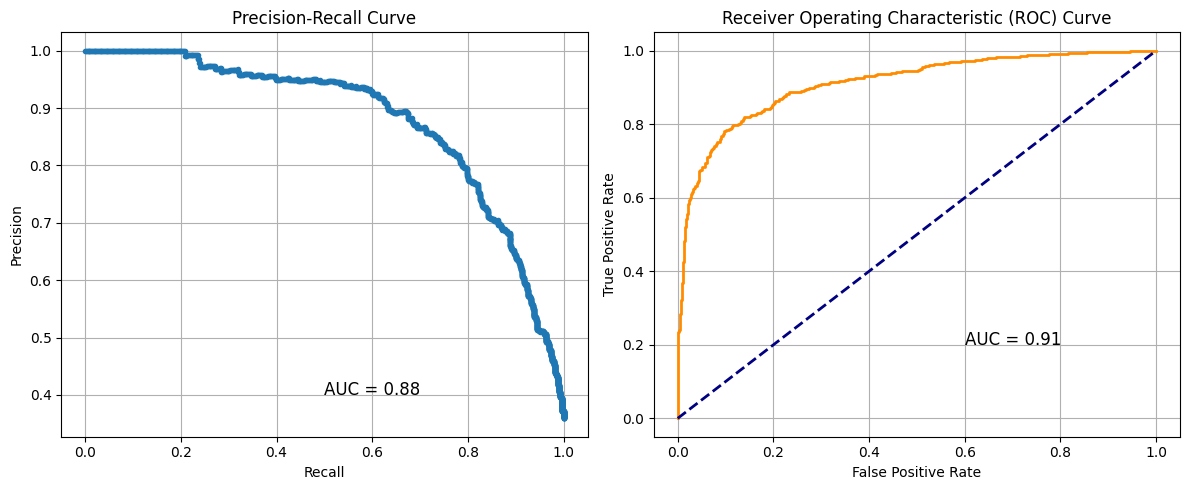

In [5]:
# -----------Hyperparameters for training-----------------
embed_size = X_embeddings_train.shape[1]  # Embedding size (last dimension of input shape)
finger_size= X_finger_train.shape[1]  # Fingerprint size
num_heads = 768  # Number of heads in multi-head attention layer
ff_dim = 185  # Hidden layer size in feedforward layer of transformer block
dropout = 0.2639611949520379   # Dropout rate
hidden_size=219   # Hidden size of the MLP
total_epochs = 140   # Total number of epochs to train for
lr = 0.0019  # Learning rate
T_max =  83   # Number of epochs for cosine annealing scheduler
eta_min = 6.126172075318459e-05   # Minimum learning rate for cosine annealing scheduler
num_experiments = 1  # Number of experiments to run
mntum=0.8629161261798225   # momentum for SGD optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = torch.nn.BCELoss()
# -----------Hyperparameters for training-----------------



test_roc=[]

print('\n\nTraining on {}'.format(device))
print(torch.cuda.get_device_properties(device))
print('========================================================\n')


for exp in range(num_experiments):
    # Initialize the model
    model = TransformerCl(embed_size, finger_size, num_heads, ff_dim, dropout, hidden_size)
    model.to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8629161261798225)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    # train model
    print('\n********************')
    print('Experiment {}/{}'.format(exp+1, num_experiments))
    print('********************\n')
    for epoch in range(total_epochs):
        run_loss = 0.0
        for i, (inputs, inputs_f, targets) in enumerate(train_loader):
            inputs, inputs_f, targets = inputs.to(device), inputs_f.to(device), targets.to(device)
            inputs = torch.unsqueeze(inputs, 1)
            optimizer.zero_grad()
            outputs = model(inputs, inputs_f)
            # outputs = torch.squeeze(outputs)
            targets = torch.unsqueeze(targets, 1)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            run_loss += loss.item()
        
        run_loss /= len(train_loader)

        if (epoch+1) % 10 == 0 or epoch == 0 or epoch == total_epochs-1:
            train_accuracy, train_precision, train_recall, train_f1,  train_roc = evaluate_model(model, train_loader, device)
            test_accuracy, test_precision, test_recall, test_f1, test_roc = evaluate_model(model, test_loader, device)

            print('Epoch: {}/{}, Loss: {:.4f}'.format(epoch+1, total_epochs, run_loss))
            print('Train Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, AUC-ROC: {:.4f}'.format(train_accuracy, train_precision, train_recall, train_f1, train_roc))
            print('Test Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, AUC-ROC: {:.4f}'.format(test_accuracy, test_precision, test_recall, test_f1, test_roc))

            model.train()
            print("---------------------------------------------------------------------------------------------------------")

        scheduler.step()

    prc(model,test_loader,device) 
    torch.save(model.state_dict(), 'model_exp'+str(exp)+'_'+str(test_roc)+'ROCAUC.pt')
    test_roc.append(test_roc) 
    print('\n')   


